# **_Chess Piece Validation Model_**

### __*This CNN is supposed can determine what kind of Chess Piece is in the Image from the original Dataset*__

<br>

### __*Import Libraries and choose the device*__

In [1]:
# Import of the Libraries
import os
import csv
import numpy as np
import pandas as pd
import random as rand
import skimage
import matplotlib.pyplot as plt

# Torch libraries
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Device config (Pick your set-up)
# GPU = torch.device('cpu')  # CPU
GPU = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # NVIDIA GPUs
# GPU = torch.device('mps' if torch.has_mps else 'cpu')  # ARM GPUs (M1, M2, ...)
print('Using the Processor') if GPU == torch.device('cpu') else print('Using the Graphics Card')

Using the Graphics Card


<br>

### __*Create the .csv file for Dataset*__

In [2]:
def create_csv( file_path, csv_path=False, train_csv=False, test_csv=False, rewrite=False, split=False, test_ratio=0.2, mul=1, mul_test=False):
    translate = dict()                                  # Class : Number
    categories = os.listdir(file_path)                  # Load all categories

    # Create an indexing dictionary
    for idx in range(len(categories)):
        translate[categories[idx]] = idx


    # Create one csv file
    if not split:
        if csv_path and not os.path.exists(csv_path) or rewrite:
            file = open(csv_path, 'w', newline='')      # Create the csv file
            writer = csv.writer(file)                   # Create a writer for csv file

            # Create a .csv file of all images & their class
            for idx in range(len(categories)):
                tmp_path = os.path.join(file_path, categories[idx])  # File path + Sub-File
                tmp_images = os.listdir(tmp_path)
                for img in tmp_images:
                    img_path = os.path.join(categories[idx], img)  # Sub-File + img
                    for _ in range(mul):                # Expand the dataset
                        writer.writerow((img_path, idx))
            file.close()                                # Close the file


    # Create train & test csv file
    if split:
        if (train_csv and test_csv) and (not os.path.exists(train_csv) or not os.path.exists(test_csv) or rewrite):
            train_f = open(train_csv, 'w', newline='')  # Create the train csv file
            test_f = open(test_csv, 'w', newline='')    # Create the test csv file
            train_writer = csv.writer(train_f)          # Create a writer for train csv file
            test_writer = csv.writer(test_f)            # Create a writer for test csv file

            # Create the .csv files of all images & their class
            for idx in range(len(categories)):
                tmp_path = os.path.join(file_path, categories[idx])
                tmp_images = os.listdir(tmp_path)
                test_split = int(len(tmp_images) / 100 * (test_ratio * 100))
                rand_dir = sorted(rand.sample(range(0, len(tmp_images)), test_split))
                train_idx = 0
                for img in tmp_images:
                    img_path = os.path.join(categories[idx], img)
                    if train_idx in rand_dir and mul_test:
                        for _ in range(mul):
                            test_writer.writerow((img_path, idx))
                    elif train_idx in rand_dir:
                        test_writer.writerow((img_path, idx))
                    else:
                        for _ in range(mul):
                            train_writer.writerow((img_path, idx))
                    train_idx += 1
            train_f.close()                             # Close the file
            test_f.close()                              # Close the file

    return translate

<br>

### __*Convert the Images into a Dataset*__

In [3]:
class ChessDataset(Dataset):

    def __init__(self, file_path, csv_path, transform=None):
        self.annotations = pd.read_csv(csv_path)
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.file_path, self.annotations.iloc[index, 0])
        image = skimage.io.imread(img_path)
        y_label = torch.tensor(self.annotations.iloc[index, 1])

        if self.transform:
            image = self.transform(image)

        return image, y_label

<br>

### __*Convolutional Neural Network*__

In [4]:
class ConvNet(nn.Module):
    def __init__(self, colour, n_categories):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(colour, 6, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 4)
        self.fc1 = nn.Linear(16 * 19 * 19, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_categories)


    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 19 * 19)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

<br>

### __*Testing Preparation*__

In [5]:
# Hyper-parameters
num_epochs = 30         # How many times to repeat learning
batch_size = 8          # Number of images to send at once
learning_rate = 0.01    # How quickly should it learn
steps_per_epoch = 1     # Number of prints per epoch

# Image Dimensions
IMG_SIZE = 85  # 85*85 pixels

# Define the directory
FILE_PATH = './data/chess/pieces'           # Sub-Folders Location
TRAIN_CSV = './data/chess/train_data.csv'   # Train CSV Location
TEST_CSV = './data/chess/test_data.csv'     # Test CSV Location
CATEGORIES = os.listdir(FILE_PATH)          # Turn Sub-Folder names into a list
N_CLASSES = len(CATEGORIES)                 # Number of different classes


# Transformation
transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Create the .csv file & dictionary
indexing = create_csv(FILE_PATH, train_csv=TRAIN_CSV, test_csv=TEST_CSV,
                      rewrite=True, split=True, test_ratio=0.2, mul=2)

# Create the Datasets
test_dataset = ChessDataset(FILE_PATH, TEST_CSV, transform=transformer)

# Create the DataLoaders
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Create the Model
model = ConvNet(3, N_CLASSES).to(GPU)

# Load Model
model.load_state_dict(torch.load('./chess100.pth'))

# Choose type of Loss & Optimization function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

#### __*Look at some data*__

Translate: {'pawn': 0, 'queen': 1, 'rook': 2, 'bishop': 3, 'king': 4, 'knight': 5}
[(0, 46), (1, 6), (2, 14), (3, 13), (4, 6), (5, 14)]
torch.Size([8, 3, 85, 85])


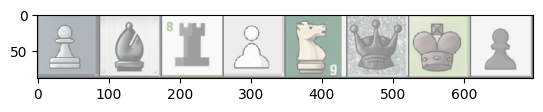

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # un-normalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


# Print Translation
print(f'Translate: {indexing}')

# Get dataset distribution
test_dct = dict()
for item in test_dataset:
    try:
        test_dct[item[1].item()] += 1
    except KeyError:
        test_dct[item[1].item()] = 1
print(sorted(test_dct.items()))

# Get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(images.shape)

# Show images
imshow(torchvision.utils.make_grid(images))

<br>

### __*Validation Loop*__

In [7]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(N_CLASSES)]
    n_class_samples = [0 for i in range(N_CLASSES)]
    for images, labels in test_loader:
        images = images.to(GPU)
        labels = labels.to(GPU)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    accuracy = 100.0 * n_correct / n_samples
    print(f'Accuracy of the Model: {accuracy:.2f} %')

    for i in range(N_CLASSES):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {CATEGORIES[i]}: {accuracy:.2f} %')

Accuracy of the Model: 100.00 %
Accuracy of pawn: 100.00 %
Accuracy of queen: 100.00 %
Accuracy of rook: 100.00 %
Accuracy of bishop: 100.00 %
Accuracy of king: 100.00 %
Accuracy of knight: 100.00 %
